In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['automobile', 'dog', 'ship', 'horse', 'deer', 'frog', 'truck', 'bird', 'cat', 'airplane']


In [ ]:
#Training class check

airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0935.png', '3912.png', '1577.png', '4635.png', '4644.png']


In [ ]:
#Testing class check

ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0935.png', '0461.png', '0018.png', '0778.png', '0084.png']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


In [ ]:
#Spliting training data for train + val set

random_seed = 42
torch.manual_seed(random_seed);  #To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
#Creating Dataloader for Training and Validation data

from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super(Cifar10CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        # self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1)

        self.fc1 = nn.Linear(256 * 4 * 4, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        # x = F.relu(self.conv5(x))
        x = F.max_pool2d(F.relu(self.conv6(x)), 2)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = Cifar10CnnModel()
model

# self.conv4 = nn.Conv2d(128, 128, 3, 1, 1)
# x = F.max_pool2d(F.relu(self.conv4(x)), 2)

Cifar10CnnModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.0985523909330368, 'val_loss': 2.303128957748413}

In [ ]:
#Defining hyper-parameters 

num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.7306, val_loss: 1.3246, val_acc: 0.5166
Epoch [1], train_loss: 1.1328, val_loss: 0.9791, val_acc: 0.6565
Epoch [2], train_loss: 0.8826, val_loss: 0.8712, val_acc: 0.6860
Epoch [3], train_loss: 0.6992, val_loss: 0.7926, val_acc: 0.7272
Epoch [4], train_loss: 0.5655, val_loss: 0.8037, val_acc: 0.7285
Epoch [5], train_loss: 0.4350, val_loss: 0.7529, val_acc: 0.7606
Epoch [6], train_loss: 0.3231, val_loss: 0.8036, val_acc: 0.7615
Epoch [7], train_loss: 0.2309, val_loss: 0.8734, val_acc: 0.7680


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

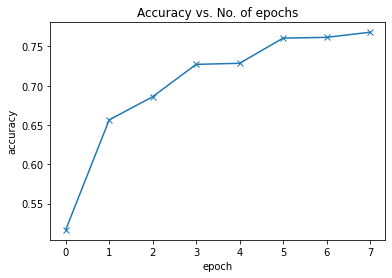

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

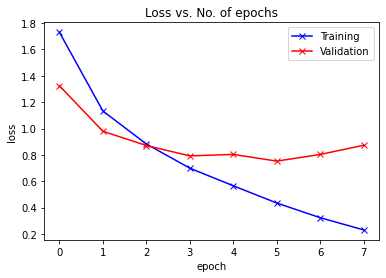

In [ ]:
plot_losses(history)

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

torch.Size([3, 32, 32])
Label: airplane , Predicted: airplane


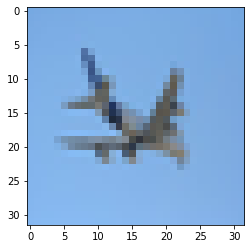

In [ ]:
img, label = test_dataset[300]
plt.imshow(img.permute(1, 2, 0))
print(img.shape)
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


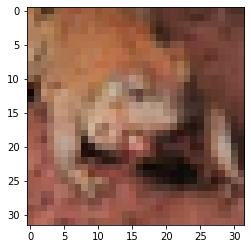

In [ ]:
img, label = test_dataset[6001]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
#Visualization - feature map

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
print(len(model_children))
#counter to keep count of the conv layers
counter = 0
print(type(model_children[0]))
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print(conv_layers)

8
<class 'torch.nn.modules.conv.Conv2d'>
Total convolution layers: 5
[Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

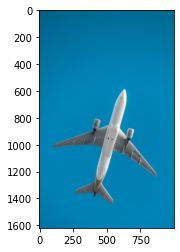

In [ ]:
#selecting a image for feature map
from PIL import Image

img = Image.open('./data/airplane.jpeg')
plt.imshow(img)

In [ ]:
image = transform(img)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
p_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
predict_image(p_transform(img), model)

'airplane'

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


Original Image Feature Map for 5 convolution and 3 FC layers(224 X 224)

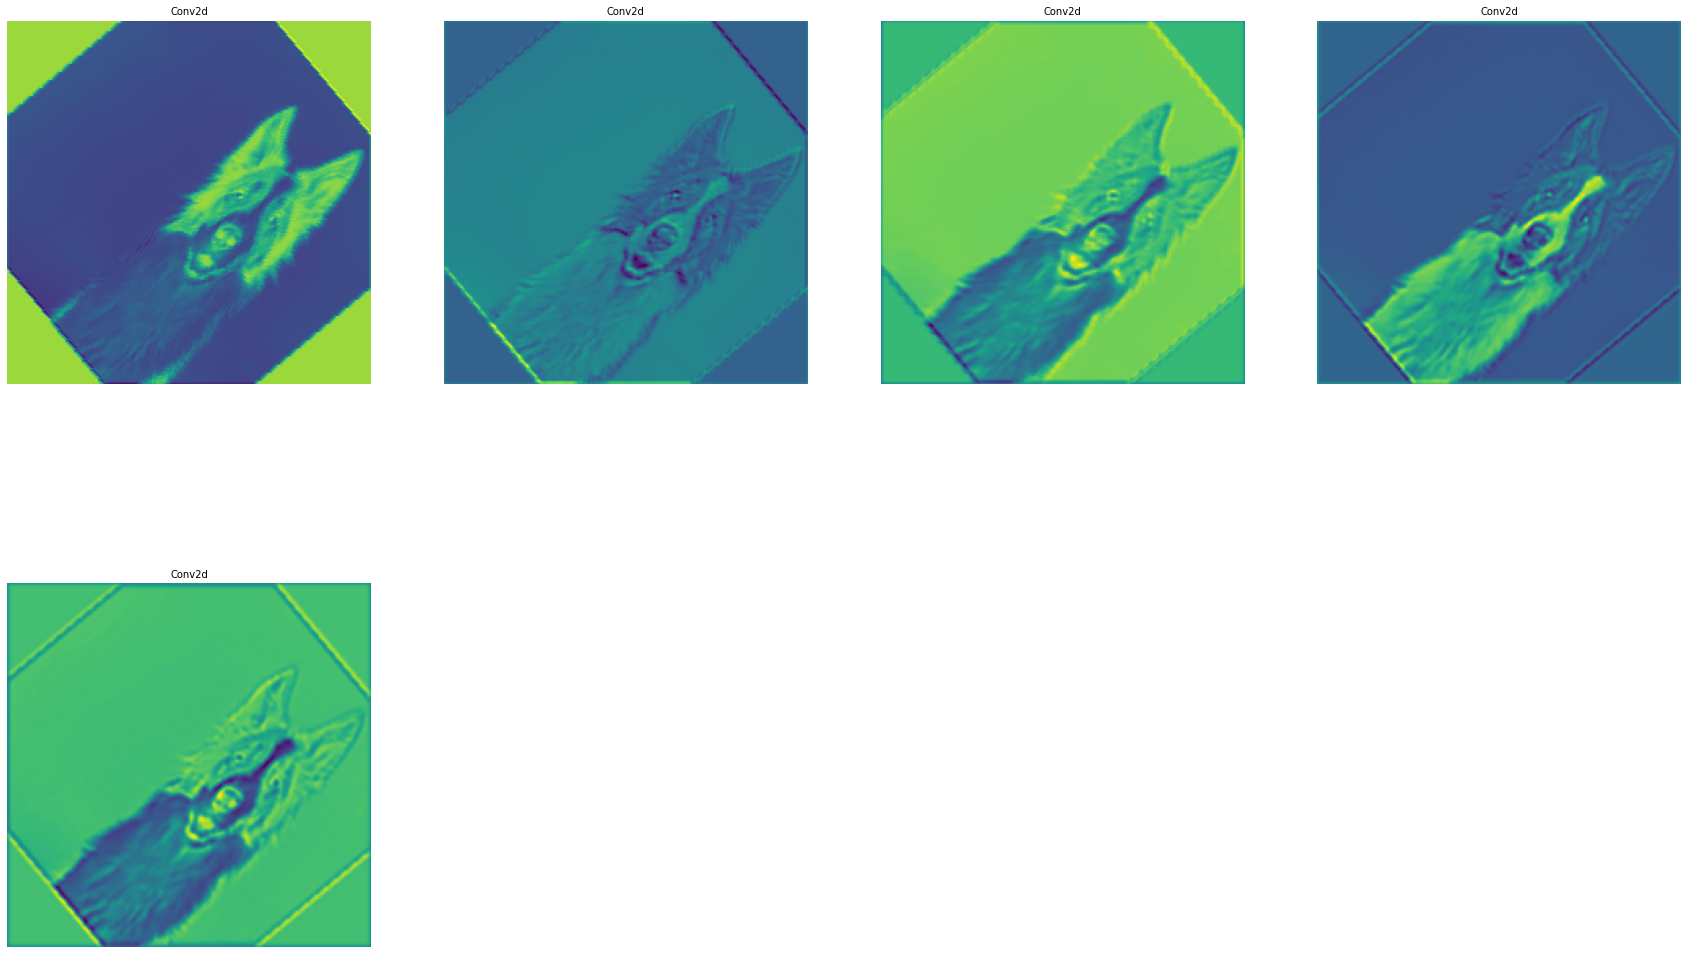

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

# New Section - Applying Traslations on the Image


# Added gaussian noise

In [ ]:
from skimage.util import random_noise

noise_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])



In [ ]:
image = noise_transform(img)
image = torch.tensor(random_noise(image, mode='gaussian', mean=0, var=0.05, clip=True))
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image=image.float()
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


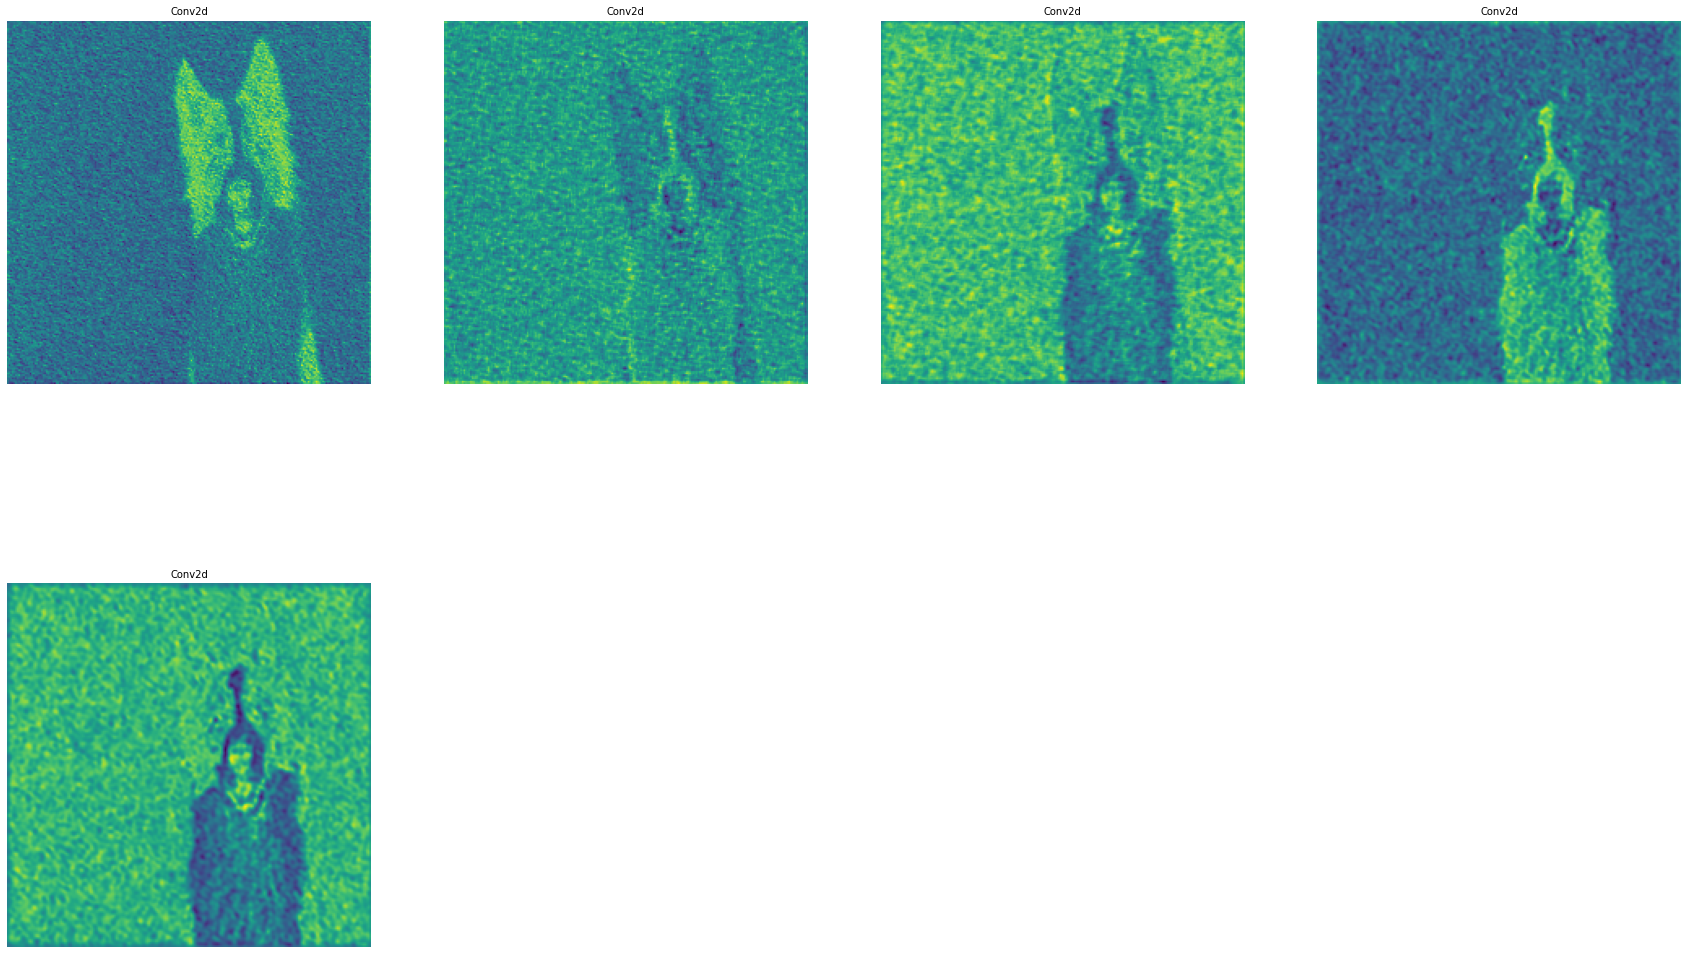

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
p_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
image = p_transform(img)
image = torch.tensor(random_noise(image, mode='gaussian', mean=0, var=0.05, clip=True))
image=image.float()
predict_image(image, model)

'cat'

## Adding Salt and Pepper noise

In [ ]:
image = noise_transform(img)
image = torch.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image=image.float()
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


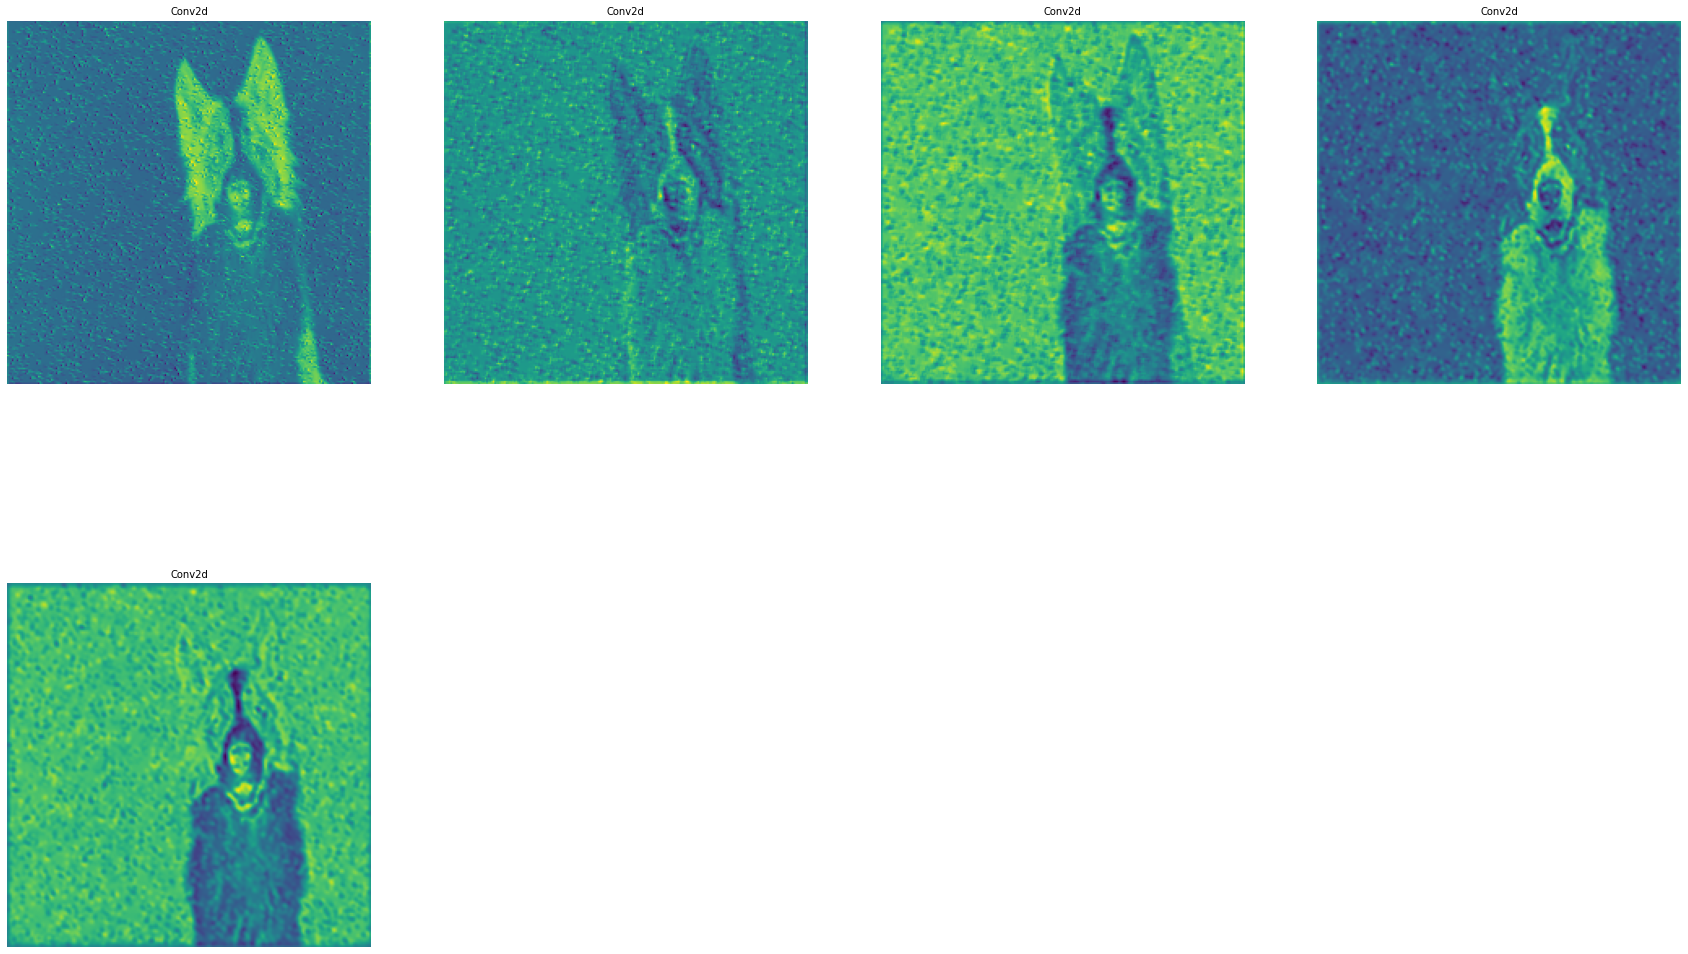

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
p_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
image = p_transform(img)
image = torch.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
image=image.float()
predict_image(image, model)

'cat'

# Adding Speckle Noise


In [ ]:
image = noise_transform(img)
image = torch.tensor(random_noise(image, mode='speckle', mean=0, var=0.05, clip=True))
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image=image.float()
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
processed = []

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


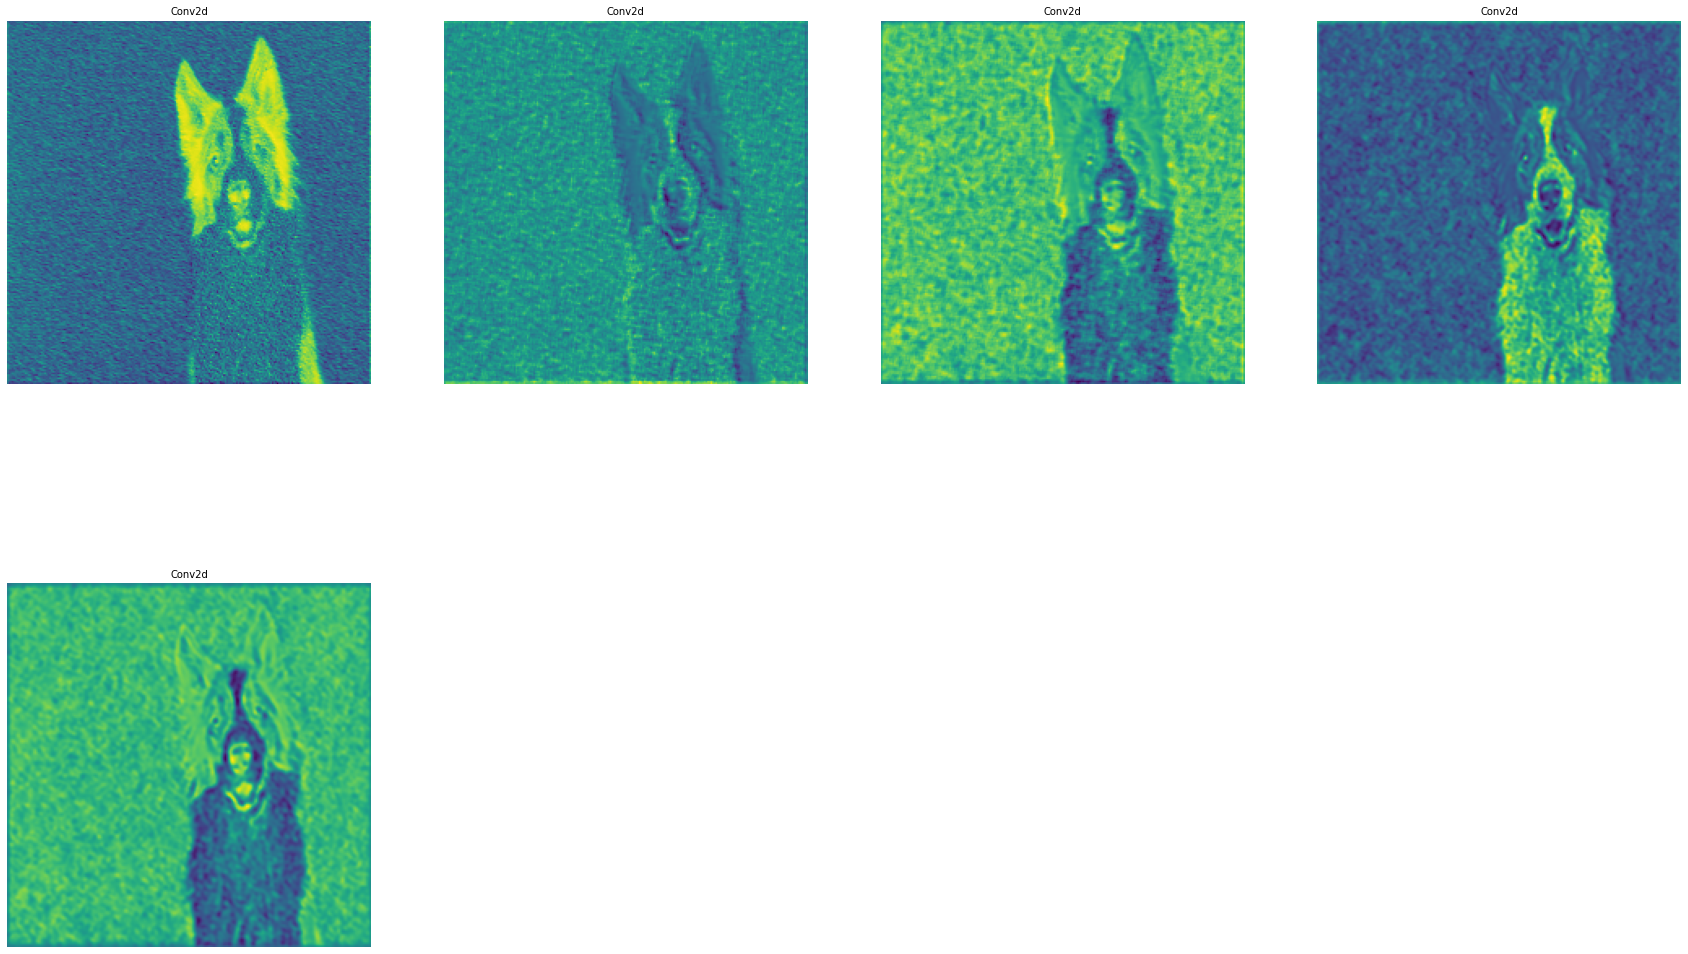

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
p_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
image = p_transform(img)
image = torch.tensor(random_noise(image, mode='speckle', mean=0, var=0.05, clip=True))
image=image.float()
predict_image(image, model)

'deer'

# Rotation - 45, 90, 135, 180 deg






In [ ]:
# rotate_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(45),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0., std=1.)
# ])

# for 90
rotate_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

# for 135
# rotate_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(105),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0., std=1.)
# ])

#for 180
# rotate_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(180),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=0., std=1.)
# ])

In [ ]:
image = rotate_transform(img)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
processed = []

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


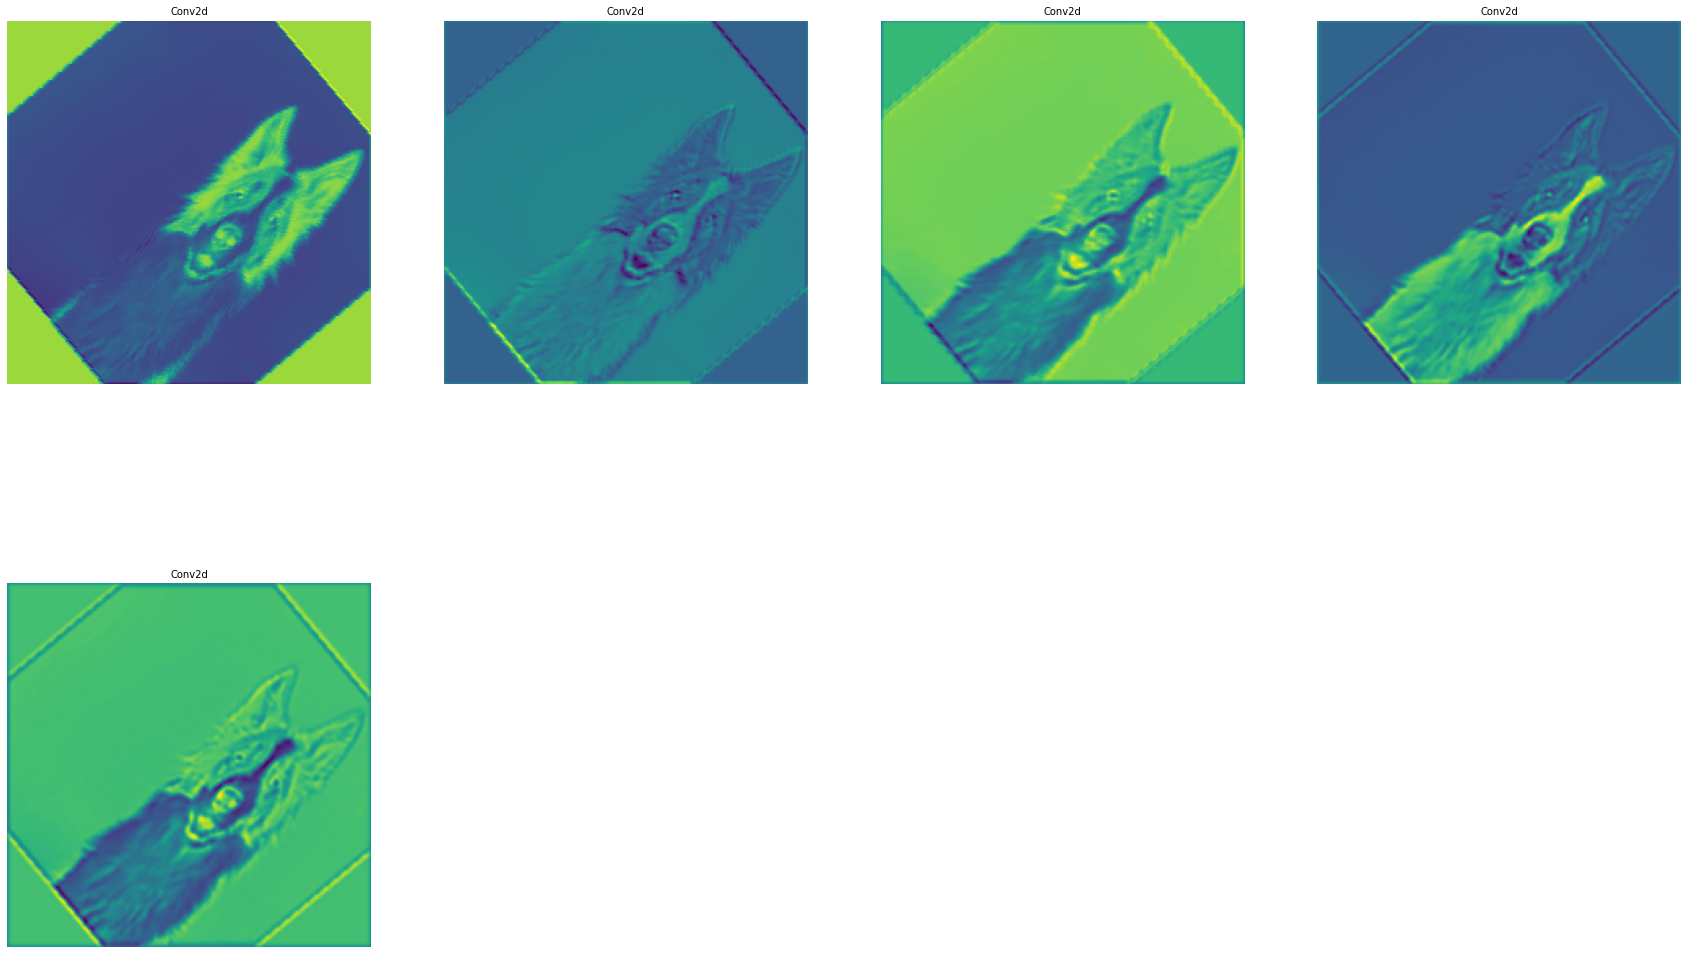

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
p_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(100),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
predict_image(p_transform(img), model)

'bird'

# Crop image transformation

In [ ]:
crop_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
image = rotate_transform(img)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [ ]:
outputs = []
names = []
processed = []

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

5
torch.Size([1, 32, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 224, 224])
torch.Size([1, 256, 224, 224])
torch.Size([1, 256, 224, 224])
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [ ]:
p_transform = transforms.Compose([
    transforms.CenterCrop(150),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])
image = p_transform(img)
image=image.float()
predict_image(image, model)

'deer'

# BGR to GreyScale Image

In [ ]:
grey_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0., std=1.)
])

In [ ]:
image = grey_transform(img)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([1, 224, 224])
Image shape after: torch.Size([1, 1, 224, 224])


In [ ]:
outputs = []
names = []
processed = []

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

RuntimeError: ignored

In [ ]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')